# Fixed Distribution Hypothesis

The Fixed Distribution Hypothesis proposes that the distribution of null-space activity does not vary freely; instead it is constrained by the output-potent activity required to perform the task accurately.

In this section, the Fixed Distribution Hypothesis will be modelled using the BCI simulation, to attempt to link the empirical observations made by Hennig et al. to the network model of M1. For each output-potent activity vector, the conditional distribution of output-null activity can be calculated and compared to the true samples. This will be compared to two other methods of generating the null-space activity. The first involves breaking the dependency of the null samples on the output potent activity, while the second is inspired by principles of minimum energy observed in muscular redundancy. If the BCI model is an accurate representation of the experimental task performed, the accuracy of the Fixed Distribution Hypothesis should be reflected in the data.

In [16]:
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from numpy.linalg import inv
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.ticker as ticker

In [3]:
numpy_data_folder = 'Arm Model and Intrinsic Manifold Files/'
A = np.load(numpy_data_folder + 'A.npy')
B = np.load(numpy_data_folder + 'B.npy')
H_BAR = np.load(numpy_data_folder+ 'H_BAR.npy')
COVARIANCE = np.load(numpy_data_folder + 'COVARIANCE.npy')
ORTH_BASIS = np.load(numpy_data_folder + 'ORTH_BASIS.npy')
INTRINSIC_MANIFOLD = np.load(numpy_data_folder + 'INTRINSIC_MANIFOLD.npy')
spontaneous_activity = np.load(numpy_data_folder + 'spontaneous_activity.npy')

# 1. Generate Data

To collect a large sample of the activity withthe maximum amount of variance possible, the optimal tracking paradigm was used to track a 30-minute long gaussian process.  

In [4]:
dt = 0.0005
length_scale = 0.15

def generate_GP(time, variance = 40):
    
    t = np.arange(0, 2 * time, dt)
    N = len(t)
    DFT_N = int(N/2)+1
    GP = np.empty((2, DFT_N))

    for j in range(2):
        fourier_vector = np.fft.rfft(np.random.normal(0, variance, N))
        omega  = np.linspace(0, 2*np.pi/dt, len(fourier_vector))
        fourier_covariance = np.exp(-(omega*length_scale/2)**2/2)
        GP[j,:] = np.fft.ifft(fourier_covariance*fourier_vector)
        
    return GP, t[:DFT_N], DFT_N

long_GP, t, N = generate_GP(300)
print(np.shape(long_GP))

<ipython-input-4-d52bcab3c950>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  GP[j,:] = np.fft.ifft(fourier_covariance*fourier_vector)


(2, 600001)


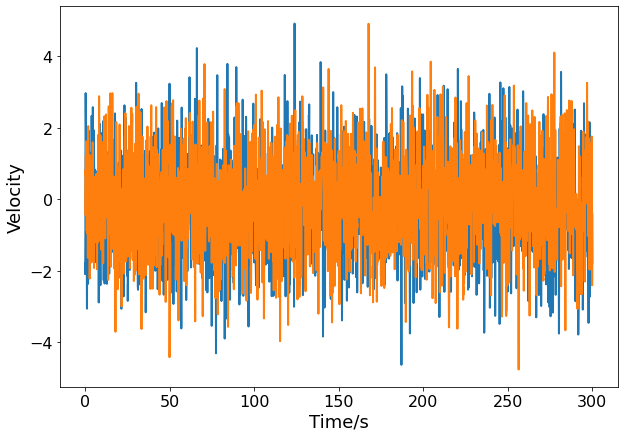

In [5]:
#Plot Gaussian Process and Step
fig, ax  = plt.subplots(figsize = (10,7))
ax.plot(t, long_GP.T, linewidth = 2)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_xlabel("Time/s", fontsize = 18)
ax.set_ylabel("Velocity", fontsize = 18)
plt.show()

In [6]:
def LQI(A, C, lmbda_Q = 1, lmbda_R = 1):

    #Extend matrices
    A_dash = np.zeros((202, 202))
    A_dash[:200, :200] = A
    A_dash[200:202, :200] = - C
    
    B_dash = np.zeros((202, 8))
    B_dash[:200, :] = B

    G_dash = np.zeros((202,2))
    G_dash[200:202, :2] = np.identity(2)

    M_dash = np.zeros((4, 2))
    M_dash[:2, :2] = np.identity(2)

    H_BAR_dash = np.zeros(202)
    H_BAR_dash[:200] = H_BAR

    C_dash = np.zeros((4,202))
    C_dash[:2, :200] = - C
    C_dash[2:, 200:202] = np.identity(2)
    
    R = lmbda_R * np.identity(8)
    Q = lmbda_Q * np.identity(4)
    
    #Solve Riccati Equaiton
    X_ss = sp.linalg.solve_continuous_are(A_dash, B_dash, C_dash.T @ Q @ C_dash, R)
    
    #OPTIMAL CONTROLLER
    K_x = np.linalg.inv(R) @ B_dash.T @ X_ss
    K_v = np.linalg.inv(R) @ B_dash.T @ np.linalg.inv(X_ss @ B_dash @ np.linalg.inv(R) @ B_dash.T - A_dash.T)@(C_dash.T @ Q @ M_dash + X_ss@G_dash)
    
    #Closed loop dynamics
    A_BAR = A_dash - B_dash @ K_x
    B_BAR = G_dash - B_dash @ K_v
    
    return A_BAR, B_BAR, H_BAR_dash, K_x, K_v, C_dash

In [7]:
def tracking(A, B, x, v, H_BAR_dash):
    dxdt = A @ x + B @ v + H_BAR_dash
    return dxdt

def solve_tracking(x0, dt, num_steps, A, B, v, K_x, K_v, C_dash, H_BAR_dash):
    x = np.zeros((202, num_steps))
    x[:200,0] = x0

    for step in range(num_steps-1):
        x[:, step+1] = x[:, step] + tracking(A, B, x[:, step], v[:, step], H_BAR_dash) * dt
        
    return x

They samples collected must first be aligned with the control space such that the first two components of the activity correspond to the output-potent activity while the following 198 component correspond to output-null activity.. This was done by first finding the orthogonal complement of the mapping $\boldsymbol{C}$. $\boldsymbol{C}$ has shape $(2,200)$, so its complement has shape $(198,200)$. These are then stacked together to form $\boldsymbol{Q}$, which has shape $(200,200)$. The transformed data $\boldsymbol{y}$ is then formed by $\boldsymbol{y} = \boldsymbol{Qx}$. The first two rows of $\boldsymbol{y}$ are now aligned with the output-potent directions of $\boldsymbol{C}$, while the subsequent 198 rows are aligned with the output-null directions of $\boldsymbol{C}$.

In [8]:
#DENOTE THE ORTHOGONAL COMPLEMENT OF THE CHOSEN COLUMNS OF THE INTRINSIC MANIFOLD AS C_TILDE
C = INTRINSIC_MANIFOLD[:, [0,1]].T
A_BAR, B_BAR, H_BAR_dash, K_x, K_v, C_dash = LQI(A, C, 1)

u, sigma, vT = sp.linalg.svd(C)
Q = vT.T
C_BAR = Q[:, 2:]
print(np.shape(C_BAR))
print(np.linalg.norm(Q[:,0]))
print(Q[:,0]@Q[:,3])

(200, 198)
0.9999999999999999
6.938893903907228e-18


In [9]:
parts = 30
length = int((N-1)/parts)

In [10]:
sectioned_GP = []

for i in range(parts):
    section = long_GP[:, i*length:(i+1)*length+1]
    sectioned_GP.append(section)

x_activity_sections = []
y_activity_sections = []
v_tracking_sections = []

for i, section in tqdm(enumerate(sectioned_GP)):
    x_ext = solve_tracking(spontaneous_activity, dt, length+1, A_BAR, B_BAR, section, K_x, K_v, C_dash, H_BAR_dash)
    
    x = x_ext[:200,:]
    y = Q.T @ x
    velocity = C @ x
    
    if i == 0:
        x_activity_sections.append(x)
        y_activity_sections.append(y)
        v_tracking_sections.append(velocity)
        
    else:
        x_activity_sections.append(np.delete(x, 0, 1))
        y_activity_sections.append(np.delete(y, 0, 1))
        v_tracking_sections.append(np.delete(velocity, 0, 1))
        
x = np.hstack(x_activity_sections)
y = np.hstack(y_activity_sections)
v = np.hstack(v_tracking_sections)

30it [00:16,  1.77it/s]


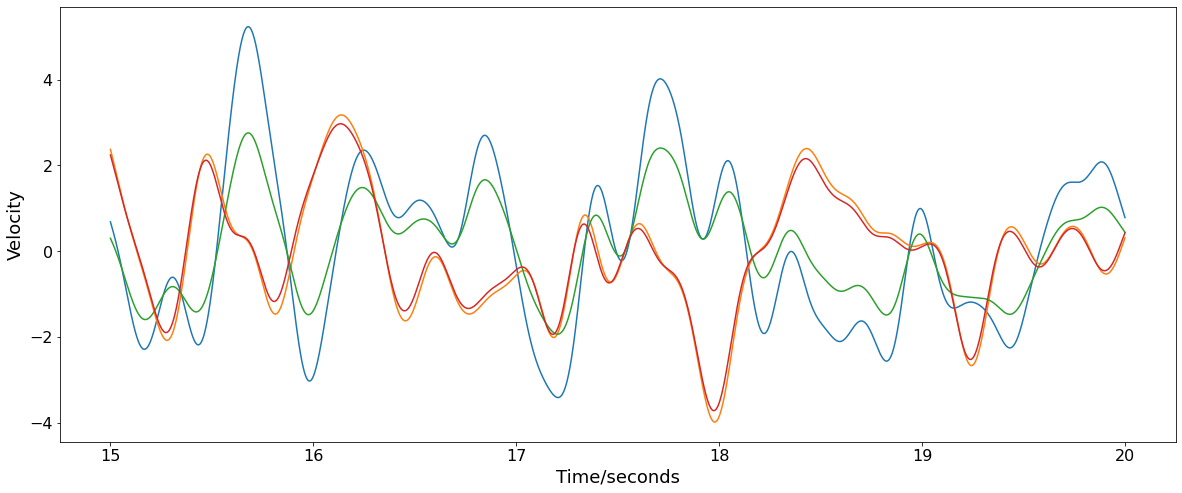

In [11]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(t[30000:40000], v[:, 30000:40000].T)
ax.plot(t[30000:40000], long_GP[:, 30000:40000].T)
ax.set_xlabel('Time/seconds', fontsize = 18)
ax.set_ylabel('Velocity', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

# 2. Activity Partitioning

Now that we have collected our data and aligned it with the control space, we are going to partition it by the output potent activity. Define a 10x10 grid across the range of both components of the potent activity. Each component of data point is then added to a list corresponding to the grid square the potent activity falls under.

In [12]:
def partition_data(y):
    
    y_potent_1 = y[0,:]
    y_potent_2 = y[1,:]
    y_null_1 = y[2, :]
    y_null_2 = y[3, :]
    y_null_3 = y[4, :]
    y_null_4 = y[5, :]
    
    x1_upper = np.ceil(max(y_potent_1))
    x1_lower = -np.ceil(abs(min(y_potent_1)))
    x2_upper = np.ceil((max(y_potent_2)))
    x2_lower = -np.ceil(abs(min(y_potent_2)))
    
    grid_1 = np.linspace(x1_lower, x1_upper, 11)
    grid_2 = np.linspace(x2_upper, x2_lower, 11)

    grid_centres_1 = [np.round((grid_1[i]+grid_1[i+1])/2,2) for i in range(len(grid_1)-1)]
    grid_centres_2 = [np.round((grid_2[i]+grid_2[i+1])/2,2) for i in range(len(grid_2)-1)]

    list_of_grid_squares = []

    for i in tqdm(range(10)):
        for j in range(10):

            grid_square_ij = []

            grid_square_ij_y_potent_1 = []
            grid_square_ij_y_potent_2 = []
            grid_square_ij_y_null_1 = []
            grid_square_ij_y_null_2 = []
            grid_square_ij_y_null_3 = []
            grid_square_ij_y_null_4 = []

            for d in range(np.shape(y)[1]):
                if grid_1[j] <= y_potent_1[d] and y_potent_1[d] < grid_1[j+1] and grid_2[i] > y_potent_2[d] and y_potent_2[d] >= grid_2[i+1]:
                    grid_square_ij_y_potent_1.append(y_potent_1[d])
                    grid_square_ij_y_potent_2.append(y_potent_2[d])
                    grid_square_ij_y_null_1.append(y_null_1[d])
                    grid_square_ij_y_null_2.append(y_null_2[d])
                    grid_square_ij_y_null_3.append(y_null_3[d])
                    grid_square_ij_y_null_4.append(y_null_4[d])             
                else:
                    continue

            grid_square_ij.append(grid_square_ij_y_potent_1) 
            grid_square_ij.append(grid_square_ij_y_potent_2)
            grid_square_ij.append(grid_square_ij_y_null_1)
            grid_square_ij.append(grid_square_ij_y_null_2)
            grid_square_ij.append(grid_square_ij_y_null_3)
            grid_square_ij.append(grid_square_ij_y_null_4)

            list_of_grid_squares.append(grid_square_ij)
    
    return list_of_grid_squares, grid_centres_1, grid_centres_2, grid_1, grid_2

In [13]:
partitioned_samples, grid_centres_1, grid_centres_2, grid_1, grid_2 = partition_data(y)

100%|██████████| 10/10 [00:55<00:00,  5.56s/it]


In [14]:
partitioned_null_samples = [grid_square[2:] for grid_square in partitioned_samples]

We can now plot the potent activity and two components of corresponding null-space activity

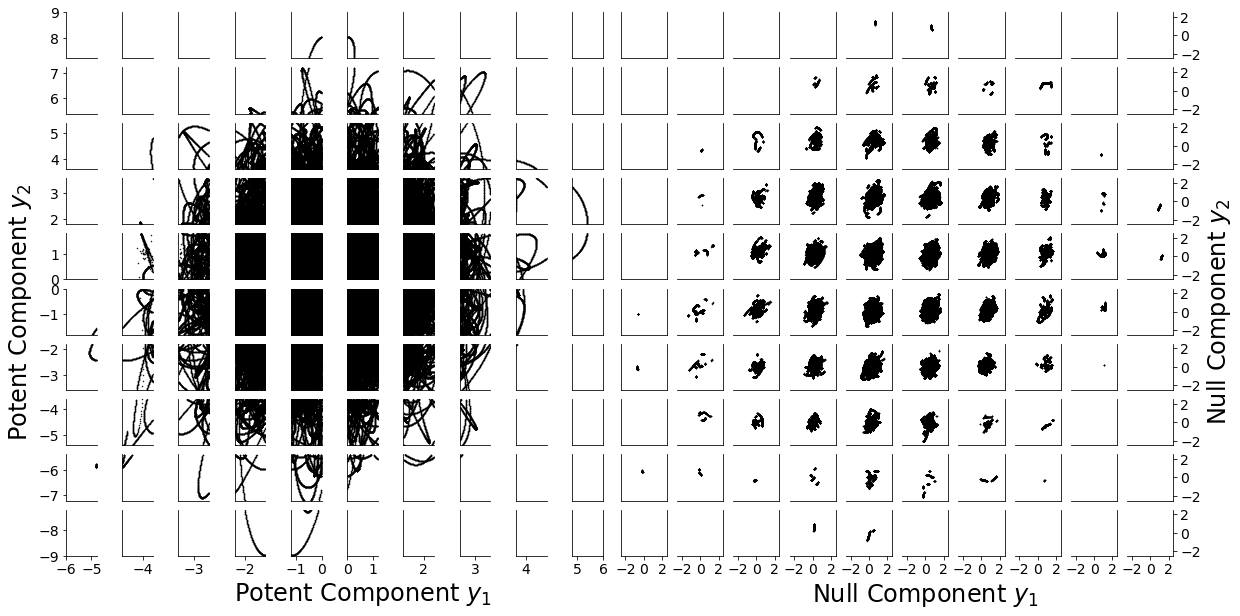

In [17]:
fig, axs = plt.subplots(10, 20, figsize = (20,10))
tick_spacing = 1

#POTENT FIRING
for i, ax1 in enumerate(axs):
    for j, ax in enumerate(ax1):
        ax.set_aspect(1)
        
        if j<10:
            ax.scatter(partitioned_samples[i*10+j][0], partitioned_samples[i*10+j][1], marker = '.', s = 1, color = 'k')
            ax.set_xlim(grid_1[j], grid_1[j+1])
            ax.set_ylim(grid_2[i+1], grid_2[i])
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            if j != 9:
                ax.spines['right'].set_visible(False) 
        
        else:
            ax.scatter(partitioned_null_samples[i*10+j-10][0], partitioned_null_samples[i*10+j-10][1], marker = '.', s = 1, color = 'k')
            ax.set_xlim(-2.5, 2.5)
            ax.set_ylim(-2.5, 2.5)
            ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
            ax.yaxis.tick_right()
            if j != 10:
                ax.spines['left'].set_visible(False) 
        
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)
        

        if j != 0 and j != 19:
            ax.set_yticks([])
        if i != 9:
            ax.set_xticks([]) 

axs[9][5].set_xlabel(r'Potent Component $y_1$', fontsize = 24)
axs[9][15].set_xlabel(r'Null Component $y_1$', fontsize = 24)
axs[5][0].set_ylabel(r'Potent Component $y_2$', fontsize = 24)
axs[5][19].yaxis.set_label_position("right")
axs[5][19].set_ylabel(r'Null Component $y_2$', fontsize = 24)
 
plt.show()

We will use the null-space activity shown in the right plot as a baseline and compare it to null-space activity generated artificially using a number of different methods. If the Fixed Distribution Hypothesis is correct, we expect the samples generated accordingly to be the closest to the actual collected samples.

# 3.1 Fixed Distribution Hypothesis

The fixed distribution hypothesis tells us that the activity in the null-space should follow a multivariate Gaussian distribution conditioned on the potent-space activity. 

For each quadrant, we will compare the distribution of sampled null-space activity with samples drawn from a conditional multivariate Gaussian. For a distribution $\boldsymbol{y} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$, with

<center>$\boldsymbol{y}=\left( \begin{array}{c}
\boldsymbol{y_p} \\
\boldsymbol{y_n} \end{array} \right),
\hspace{0.1cm}$ mean vector 
$\boldsymbol{\mu}=\left( \begin{array}{c}
\boldsymbol{\mu_p} \\
\boldsymbol{\mu_n} \end{array} \right)\hspace{0.1cm}$ and covariance matrix
$\boldsymbol{\Sigma}=\left( \begin{array}{cc}
\boldsymbol{\Sigma}_{pp} & \boldsymbol{\Sigma}_{np}\\
\boldsymbol{\Sigma}_{pn} & \boldsymbol{\Sigma}_{nn} \end{array} \right)$</center>

where $\boldsymbol{y_p}$ is the vector of 2 potent components and $\boldsymbol{y_n}$ is the vector of 198 null components, the conditional distribution of $\boldsymbol{y_n}$ given $\boldsymbol{y_p}$ is 

<center>$p(\boldsymbol{y_n}|\boldsymbol{y_p}) = \mathcal{N}_n(\boldsymbol{\hat{\mu}_n}, \boldsymbol{\hat{\Sigma}_{n}})$</center>

with

<center>$\boldsymbol{\hat{\mu}}_n =\boldsymbol{\mu}_n + \boldsymbol{\Sigma}_{pn}^T\boldsymbol{\Sigma}_{pp}^{-1}(\textbf{y}_p-\boldsymbol{\mu}_p)$</center>


<center>$\boldsymbol{\hat{\Sigma}}_n = \boldsymbol{\Sigma}_{nn} - \boldsymbol{\Sigma}_{pn}^T\boldsymbol{\Sigma}_{pp}^{-1}\boldsymbol{\Sigma}_{pn}
$</center>

In [18]:
def conditional_Gaussian_parameters(data, grid_coord): 

    yp1 = np.asarray(data[grid_coord][0])
    yp2 = np.asarray(data[grid_coord][1])
    
    yn1 = np.asarray(data[grid_coord][2])
    yn2 = np.asarray(data[grid_coord][3])
    yn3 = np.asarray(data[grid_coord][4])
    yn4 = np.asarray(data[grid_coord][5])
    
    y = np.vstack([yp1, yp2, yn1, yn2, yn3, yn4])
    N = np.shape(y)[1]
    
    mu_p = np.mean(y[:2, :], axis = 1)
    mu_n = np.mean(y[2:, :], axis = 1)
    cov = np.cov(y)

    sigma_pp = cov[:2, :2]
    sigma_nn = cov[2:, 2:]
    sigma_pn = cov[:2, 2:]
    
    y_p = np.array([grid_centres_1[grid_coord%10], grid_centres_2[int((grid_coord-grid_coord%10)/10)]])

    mu_n_hat = mu_n + sigma_pn.T@np.linalg.inv(sigma_pp) @ (y_p - mu_p)
    sigma_n_hat = sigma_nn - sigma_pn.T@np.linalg.inv(sigma_pp)@sigma_pn
    
    return mu_n_hat, sigma_n_hat, N

We can now draw samples from a multivariate Gaussian for each grid square.

In [19]:
FD_null_samples = []  # List for samples generated according to the Fixed Distribution Hypothesis
mu_n_hats = []
sigma_n_hats = []

# For each grid square
for i in tqdm(range(10)):
    for j in range(10):
        
        # Calculate the parameters of the conditional gaussian distribution and store them in a list
        mu_n_hat, sigma_n_hat, N_data_points = conditional_Gaussian_parameters(partitioned_samples, i*10+j)
        mu_n_hats.append(mu_n_hat)
        sigma_n_hats.append(sigma_n_hat)
        
        # Draw samples from a multivariate gaussian distribution parameterised by the calculated mean and covariance
        if any(np.isnan(mu_n_hat)):
            FD_null_samples.append([[],[],[],[]])
        else:
            samples = np.random.multivariate_normal(mu_n_hat, sigma_n_hat, N_data_points)
            FD_null_samples.append([*samples.T])

  0%|          | 0/10 [00:00<?, ?it/s]/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
<ipython-input-18-114dbdd6e757>:16: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(y)
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: inv

For visibility, it'll be easier to plot the contours of a gaussian rather than plotting all of the samples.

In [20]:
def plot_gaussian_contours(full_mean, full_covariance, i, j, standard_deviations = 2):

    if any(np.isnan(full_mean)):
        return [],[]
    
    #form marginal covariance
    else:
        covariance = np.array([[full_covariance[i,i], full_covariance[i,j]], 
                               [full_covariance[j,i], full_covariance[j,j]]])

        mean = np.array([full_mean[i], 
                         full_mean[j]])

        #plot a circle
        theta = np.linspace(0, 2*np.pi, 100)
        x1 = np.cos(theta)
        x2 = np.sin(theta)
        xs = np.vstack((x1,x2))

        val, vec = np.linalg.eig(covariance)
        sdxs = (standard_deviations*np.sqrt(abs(val))*xs.T).T

        theta = np.arctan(vec[1,0]/vec[0,0])

        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        sdxs = rotation_matrix@sdxs
        sdxs = (mean + sdxs.T).T
        
        return sdxs[0,:], sdxs[1,:]

In [21]:
def plot_single_conditional(test_case_samples, grid_square, null_direction_1, null_direction_2, contours = True):
    
    fig, ax = plt.subplots(figsize = (14,7))
    
    if contours:
        mu_n_hat, Sigma_n_hat, N_data_points = conditional_Gaussian_parameters(partitioned_samples, grid_square)
        gx, gy = plot_gaussian_contours(mu_n_hats[grid_square], sigma_n_hats[grid_square], null_direction_1, null_direction_2)
        ax.plot(gx,gy, color = 'w', linewidth = 5)
        ax.plot(gx,gy, color = 'r')
    
    ax.scatter(test_case_samples[grid_square][null_direction_1], test_case_samples[grid_square][null_direction_2], marker = '.', s = 10)
    ax.scatter(partitioned_null_samples[grid_square][null_direction_1], partitioned_null_samples[grid_square][null_direction_2+2], marker = '.', s = 10, color = 'k')
    
    ax.set_aspect(1)
    ax.set_xlabel('Null Component {}'.format(null_direction_1+1), fontsize = 24)
    ax.set_ylabel('Null Component {}'.format(null_direction_2+1), fontsize = 24)
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=16)

    plt.show()

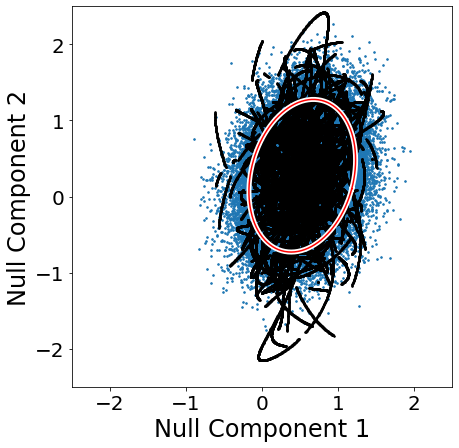

In [22]:
plot_single_conditional(FD_null_samples, 45, 0, 1)

In [23]:
def plot_all_conditional(test_case_samples, null_direction_1, null_direction_2, contours = True):
    
    fig, axs = plt.subplots(10, 10, figsize = (11,11))
    
    for i, ax1 in enumerate(axs):
        for j, ax in enumerate(ax1):
            
            ax.scatter(test_case_samples[i*10+j][null_direction_1], test_case_samples[i*10+j][null_direction_2], marker = '.', s = 1)
            
            if contours:
                x, y = plot_gaussian_contours(mu_n_hats[i*10+j], sigma_n_hats[i*10+j], null_direction_1, null_direction_2)
                ax.plot(x,y, color = 'w', linewidth = 5)
                ax.plot(x,y, color = 'r')
            
            else:
                ax.scatter(partitioned_samples[i*10+j][null_direction_1+2], partitioned_samples[i*10+j][null_direction_2+2], marker = '.', s = 1, color = 'k')
            
            
            ax.set_aspect(1)
            ax.set_xlim(-2.5, 2.5)
            ax.set_ylim(-2.5, 2.5)
            ax.set_xticks([]) 
            ax.set_yticks([])
    plt.show()

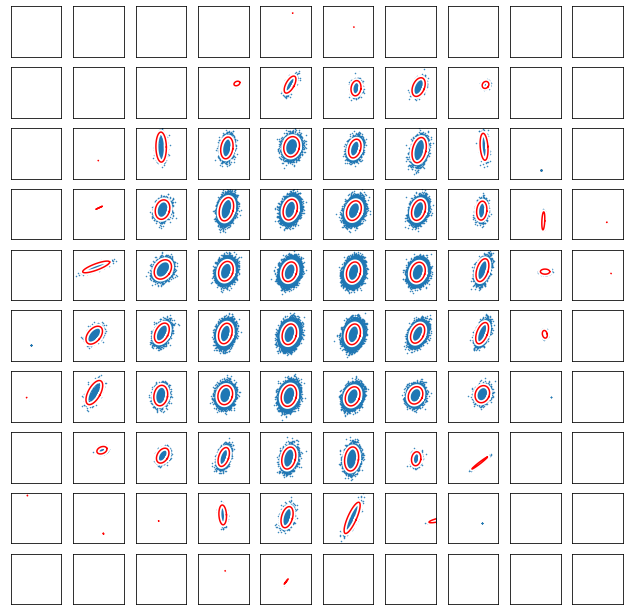

In [24]:
plot_all_conditional(FD_null_samples, 0,1)

# 3.2 Shuffle Null Space activity

One way to check the importance of the conditioning of the null-space activity on the potent activity is to break the conditioning by separating out the null-components from the potent components, shuffling them and then stacking them back together. We can then perform the same partitioning as before and see how the distribution of new null-space activity compares.

In [25]:
def shuffle_data(y):

    potent = np.empty((2, N))
    null = np.empty((198, N))
    potent[:,:] = y[:2,:]
    null[:,:] = y[2:,:]
    null_shuffled = shuffle(null.T).T
    y_shuffled = np.vstack((potent, null_shuffled))
    
    return y_shuffled

In [26]:
y_shuffled = shuffle_data(y)

In [27]:
shuffled_partitioned_samples, _,_,_,_ = partition_data(y_shuffled)

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


In [28]:
shuffled_null_samples = [grid_square[2:] for grid_square in shuffled_partitioned_samples]

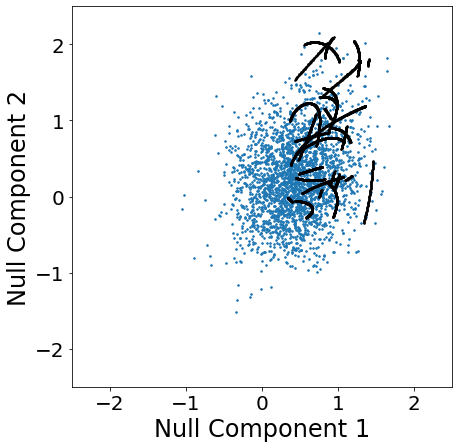

In [29]:
test_quadrant = 37
plot_single_conditional(shuffled_null_samples, test_quadrant, 0, 1, contours = False)

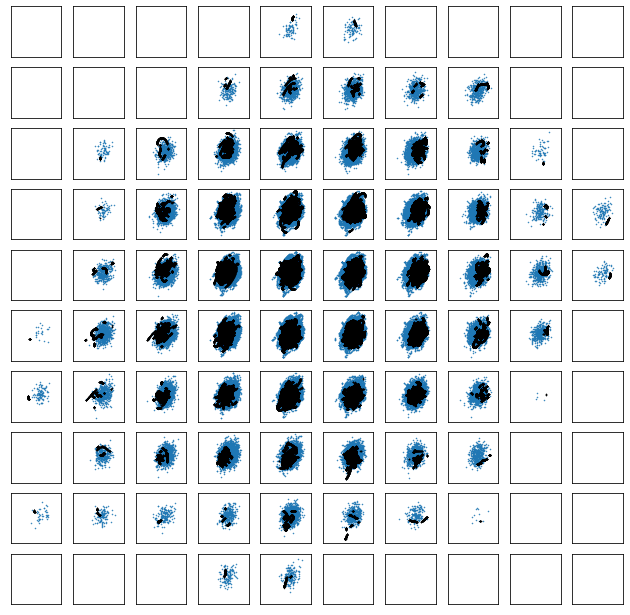

In [30]:
plot_all_conditional(shuffled_null_samples, 0, 1, contours = False)

# 3.3 Minimal Firing Hypothesis

The Minial firing hypothesis was inspired by studies of muscular redundancy, where it has been found that subjects use muscles so as to minimise total energy use. Analogously, as firing neurons costs energy, it may be that for all redundant firing patterns, the one that has the lowest total firing rate, and so the lowest energy, is selected

The vector of null-activity for a given output potent activity was found through quadratic programming:

<center>$\min \boldsymbol{x}^T\boldsymbol{x}$ subject to $\overline{\boldsymbol{Q}}^T\boldsymbol{x} = \boldsymbol{y_p}\nonumber$</center>

where $\overline{\boldsymbol{Q}}$ is the first two columns of $\boldsymbol{Q}$, such that $\overline{\boldsymbol{Q}}^T\boldsymbol{x}$ is a vector of size 2 and 3 $\boldsymbol{y_p}$ is the potent activity demanded by the task. This can be solved for every time point to define the null-space activity. This method means that for any given potent activity, there is a unique set of null activity. This is physiologically implausible, so variability was incorporated by sampling from a Poisson distribution parameterised by the solution to the quadratic programming problem: $\hat{\boldsymbol{x}} \sim \textrm{Poisson}(\boldsymbol{x})$.

With the null-activity defined, the same process of splitting the potent activity into quadrants and plotting the null-space activity was performed.

In [31]:
from qpsolvers import solve_qp

In [32]:
mu_x = np.mean(x, axis = 1)

x_min_firing = []

A = Q.T[:2,:]
q = np.zeros(200)
G = -np.identity(200)
h = np.zeros(200)
P = np.identity(200)
b = (A @ mu_x + y[:2, :].T).T


for i in tqdm(range(np.shape(y)[1])):
    x_opt = solve_qp(P, q, G, h, A, b[:,i]) - mu_x
    x_min_firing.append(x_opt)

  0%|          | 2911/600001 [00:54<3:05:42, 53.58it/s]


KeyboardInterrupt: 

In [33]:
min_firing_x = np.asarray(np.load("solved_x_min_firing.npy")).T

variable_nulls_min_firing_x = []

for i in tqdm(range(np.shape(min_firing_x)[1])):
    sign = np.sign(min_firing_x[2:,i])
    variable_nulls_min_firing_x.append(sign*(np.random.poisson(abs(min_firing_x[2:,i])*100)/100))

variable_nulls_min_firing_x = np.asarray(variable_nulls_min_firing_x).T
variable_min_firing_x = np.vstack((min_firing_x[:2,:], variable_nulls_min_firing_x))
variable_min_firing_y = Q.T@variable_min_firing_x

100%|██████████| 360001/360001 [00:31<00:00, 11558.93it/s]


In [34]:
min_firing_partitioned_samples, _, _, _, _ = partition_data(variable_min_firing_y)

100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


In [35]:
min_firing_null_samples = [grid_square[2:] for grid_square in min_firing_partitioned_samples]

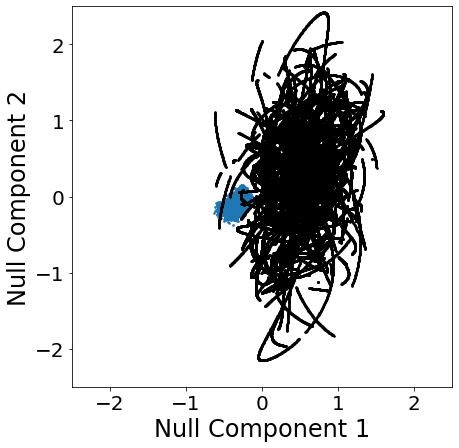

In [36]:
plot_single_conditional(min_firing_null_samples, 45, 0, 1, contours = False)

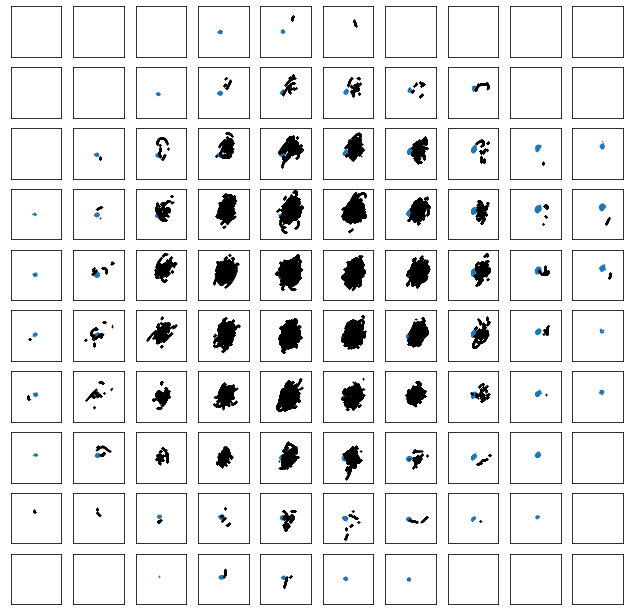

In [37]:
plot_all_conditional(min_firing_null_samples, 0, 1, contours = False)

# 4. KL Divergence

The Kullback-Leibler (KL) divergence quantifies the amount of difference between the two distributions. It can be used to compare the samples created by each model and the true null-space activity. This gives us a metric that allows comparison of different hypotheses. Identical distributions have a KL divergence of 0.

For continuous random variables, the KL Divergence is defined as
\begin{equation}
    D_{KL}(P||Q) = \int_{-\infty}^\infty p(x) log\left(\frac{p(x)}{q(x)}\right)dx
    \label{eq:KL}
\end{equation}

We model the samples as a k-dimensional multivariate normal distribution with pdf
\begin{equation}
    p(x) = (2 \pi)^{-\frac{k}{2}}\textrm{det}(\Sigma)^{-\frac{1}{2}}e^{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})}
\end{equation}
Substituting gives the KL divergence of two multivariate Gaussians.

<center>$D_{KL}(P||Q) =\frac{1}{2}[$log$\frac{|\boldsymbol{\Sigma}_2|}{|\boldsymbol{\Sigma}_1|}-k+ (\boldsymbol{\mu_1}-\boldsymbol{\mu}_2)^T\boldsymbol{\Sigma}_2^{-1}(\boldsymbol{\mu}_1-\boldsymbol{\mu}_2) + \textrm{tr}\{\boldsymbol{\Sigma}_2^{-1}\boldsymbol{\Sigma}_1\}]$</center>

We can now calculate the KL divergence of each hypothesis with respect to the true null-space activity

In [38]:
def KL_divergence(data_x1, data_y1, data_x2, data_y2):
   
    data_1 = np.vstack((data_x1, data_y1))
    data_2 = np.vstack((data_x2, data_y2))
    
    mu_1 = np.mean(data_1, axis = 1)
    sigma_1 = np.cov(data_1)

    mu_2 = np.mean(data_2, axis = 1)
    sigma_2 = np.cov(data_2)

    kl = 1/2*(np.log(np.linalg.det(sigma_2)/np.linalg.det(sigma_1)) - 2 + np.trace(np.linalg.inv(sigma_2)@sigma_1)+(mu_2-mu_1).T@np.linalg.inv(sigma_2)@(mu_2-mu_1))
    
    return kl

def all_KL_divergences(test_case_null_samples):

    all_divergences = []

    for i in tqdm(range(4)):
        for j in range(i+1, 4):
            divergences = []
            for k in range(100):
                if len(test_case_null_samples[k][i]) > 200:
                    divergences.append(KL_divergence(test_case_null_samples[k][i], test_case_null_samples[k][j], partitioned_null_samples[k][i], partitioned_null_samples[k][j]))
                else:
                    divergences.append(np.nan)
            all_divergences.append(divergences)
                
    all_divergences_array = np.asarray(all_divergences)
    return all_divergences_array

In [39]:
FD_divergences = all_KL_divergences(FD_null_samples)
shuffled_divergences = all_KL_divergences(shuffled_null_samples)
min_firing_divergences = all_KL_divergences(min_firing_null_samples)

  0%|          | 0/4 [00:00<?, ?it/s]/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
<ipython-input-38-56de137b099a>:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma_2 = np.cov(data_2)
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarn

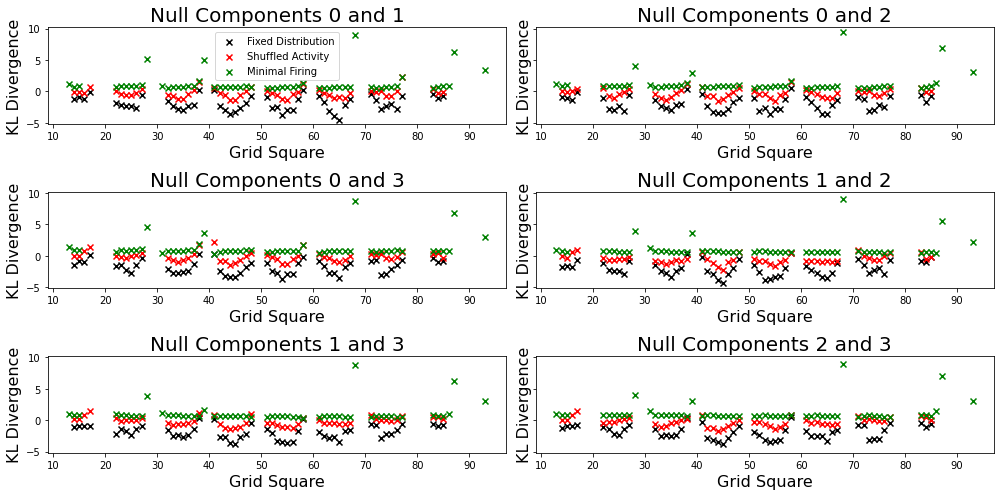

In [40]:
fix, axs = plt.subplots(3,2, figsize = (14,7), sharey = True)

title = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
for i, ax in enumerate(axs.flat):

    ax.scatter(np.arange(0,100,1), np.log10(FD_divergences[i,:]), marker = 'x', color  = 'k', label = "Fixed Distribution")
    ax.scatter(np.arange(0,100,1), np.log10(shuffled_divergences[i,:]), marker = 'x', color = 'r', label  = "Shuffled Activity")
    ax.scatter(np.arange(0,100,1), np.log10(min_firing_divergences[i,:]), marker = 'x', color = 'g', label = "Minimal Firing")
    ax.set_ylabel("KL Divergence", fontsize = 16)
    ax.set_xlabel("Grid Square", fontsize = 16)
    ax.set_title("Null Components {} and {}".format(title[i][0], title[i][1]), fontsize = 20)
    
axs[0][0].legend()
plt.tight_layout()
plt.show()